In [3]:
%load_ext autoreload
%autoreload 2

In [31]:
import jax 
import jax.config 
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import privacy_accounting as pa
import dp_matrix_factorization.loops as loops

In [4]:
dimensionality = 10
s_matrix = np.tril(np.ones(shape=(dimensionality, dimensionality)))

In [5]:
results = loops.compute_h_fixed_point_iteration(
    s_matrix=jnp.array(s_matrix),
    rtol=1e-3,
    max_iterations=100,
)

2023-01-03 16:18:20.776953: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
C = results["H"]
B = results["W"]

In [7]:
B @ C

Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float64)

In [77]:
max_col_norm_C = np.max(np.sqrt((C**2).sum(axis=1)))
max_data_abs_value = 1
sensitivity = 2 * max_col_norm_C * max_data_abs_value

n_stops = 30
epsilon = 1
delta = n**-3
sigma_dp = pa.sigma(epsilon, delta, sensitivity)

In [78]:
bus_capacity = 78
lambd = 2.0

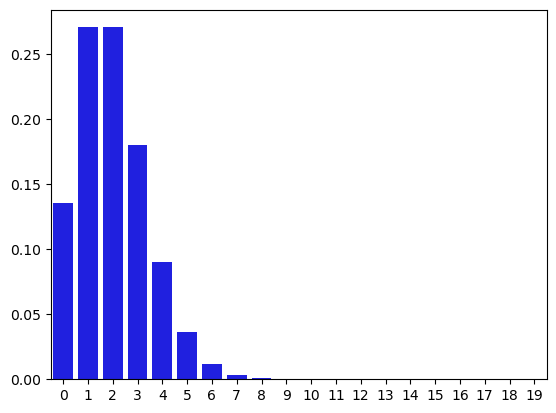

In [79]:
xs = np.arange(20)
ys = stats.poisson.pmf(xs, lambd)
sns.barplot(x=xs, y=ys, color="blue")
plt.show()

In [80]:
current_passengers = 0
passengers_to_get_off = np.zeros(n_stops)
passenger_changes = np.zeros(n_stops)
passenger_numbers = np.zeros(n_stops)
for i in range(n_stops):
    passengers_before = current_passengers
    current_passengers -= passengers_to_get_off[i]
    new_passengers = np.random.poisson(lambd)
    for j in range(new_passengers):
        # Don't go over bus capacity
        if current_passengers == bus_capacity: break
        stop_to_get_off = np.random.randint(j + 1, n_stops)
        passengers_to_get_off[stop_to_get_off] += 1
        current_passengers += 1
    passenger_change = current_passengers - passengers_before
    passenger_changes[i] = passenger_change
    passenger_numbers[i] = current_passengers
    
assert((passenger_changes.cumsum() == passenger_numbers).all())

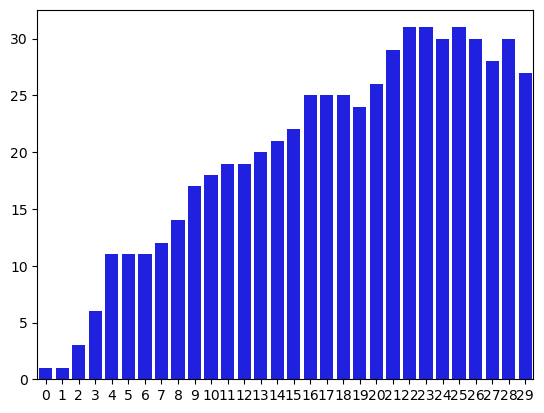

In [81]:
sns.barplot(x=np.arange(n_stops), y=passenger_numbers, color="blue")
plt.show()

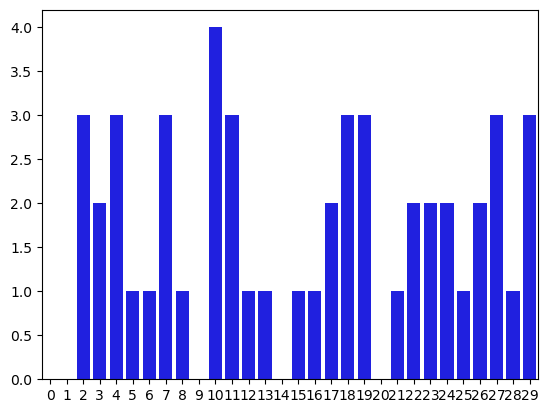

In [82]:
sns.barplot(x=np.arange(n_stops), y=passengers_to_get_off, color="blue")
plt.show()

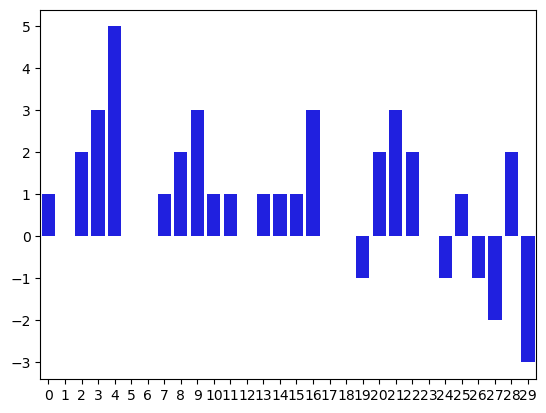

In [83]:
sns.barplot(x=np.arange(n_stops), y=passenger_changes, color="blue")
plt.show()